In [92]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sbn
# Configuring Matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
savefig_options = dict(format="png", dpi=300, bbox_inches="tight")
# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist


def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

def kalmanFilter(predictions: np.ndarray, process_noise = 1e-1, measurement_var = 0.1) -> np.ndarray:
    '''
    Inputs: 
        - Context predictions (e.g. slope, walking speed, etc.)
        - Process noise for predictions
        - Measurement uncertainty (in the form of variance)
        
    Output:
        - Updated estimates of context
    '''
    
    estimates = []

    # Initialize            
    prior_estimate = predictions[0]
    prior_var = 0.1
    
    for i in range(len(predictions)):

        slope_measurement = np.float64(predictions[i])

        # Update
        kalman_gain = prior_var / (prior_var + measurement_var) # Kn
        estimate = prior_estimate + kalman_gain*(slope_measurement-prior_estimate) # Xnn
        estimates.append(estimate)
        estimate_var = (1-kalman_gain)*prior_var # Pnn
        
        # Dynamics
        prior_estimate = estimate
        prior_var = estimate_var + process_noise

    return estimates

def analysisFastDTW(arr1, arr2):
    start = time.time()
    distMatrix = []
    warpMatrix = []
    for i in range(3):
        dtw_distance, warp_path = fastdtw(arr1[:,i], arr2[:,i], dist=euclidean)
        distMatrix.append(dtw_distance)
        warpMatrix.append(warp_path)
    print(time.time() - start)
    return distMatrix, warp_path

def loadwithKalman(arrPath):
    arr = np.loadtxt(arrPath,
                 delimiter=",", dtype=float)
    arr[:,0] = kalmanFilter(arr[:,0],process_noise=0.005, measurement_var=0.7)
    arr[:,1] = kalmanFilter(arr[:,1],process_noise=0.005, measurement_var=0.7)
    arr[:,2] = kalmanFilter(arr[:,2],process_noise=0.005, measurement_var=0.7)
    return arr

In [2]:
arr1 = np.loadtxt("../imuData/test1.csv",
                 delimiter=",", dtype=float)
arr2 = np.loadtxt("../imuData/test2.csv",
                 delimiter=",", dtype=float)


In [4]:
# cost_matrix = compute_accumulated_cost_matrix(arr1[:,0], arr2[:,0])


# fig, ax = plt.subplots(figsize=(12, 8))
# ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
# ax.invert_yaxis()

# # Get the warp path in x and y directions
# path_x = [p[0] for p in warp_path]
# path_y = [p[1] for p in warp_path]

# # Align the path from the center of each cell
# path_xx = [x+0.5 for x in path_x]
# path_yy = [y+0.5 for y in path_y]

# ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

# fig.savefig("ex1_heatmap.png", **savefig_options)

In [15]:
distMatrix, warpMatrix = analysisFastDTW(arr1, arr2)
print(distMatrix)

0.8890016078948975
[164.6540365722657, 133.37937835286448, 137.17259184977223]


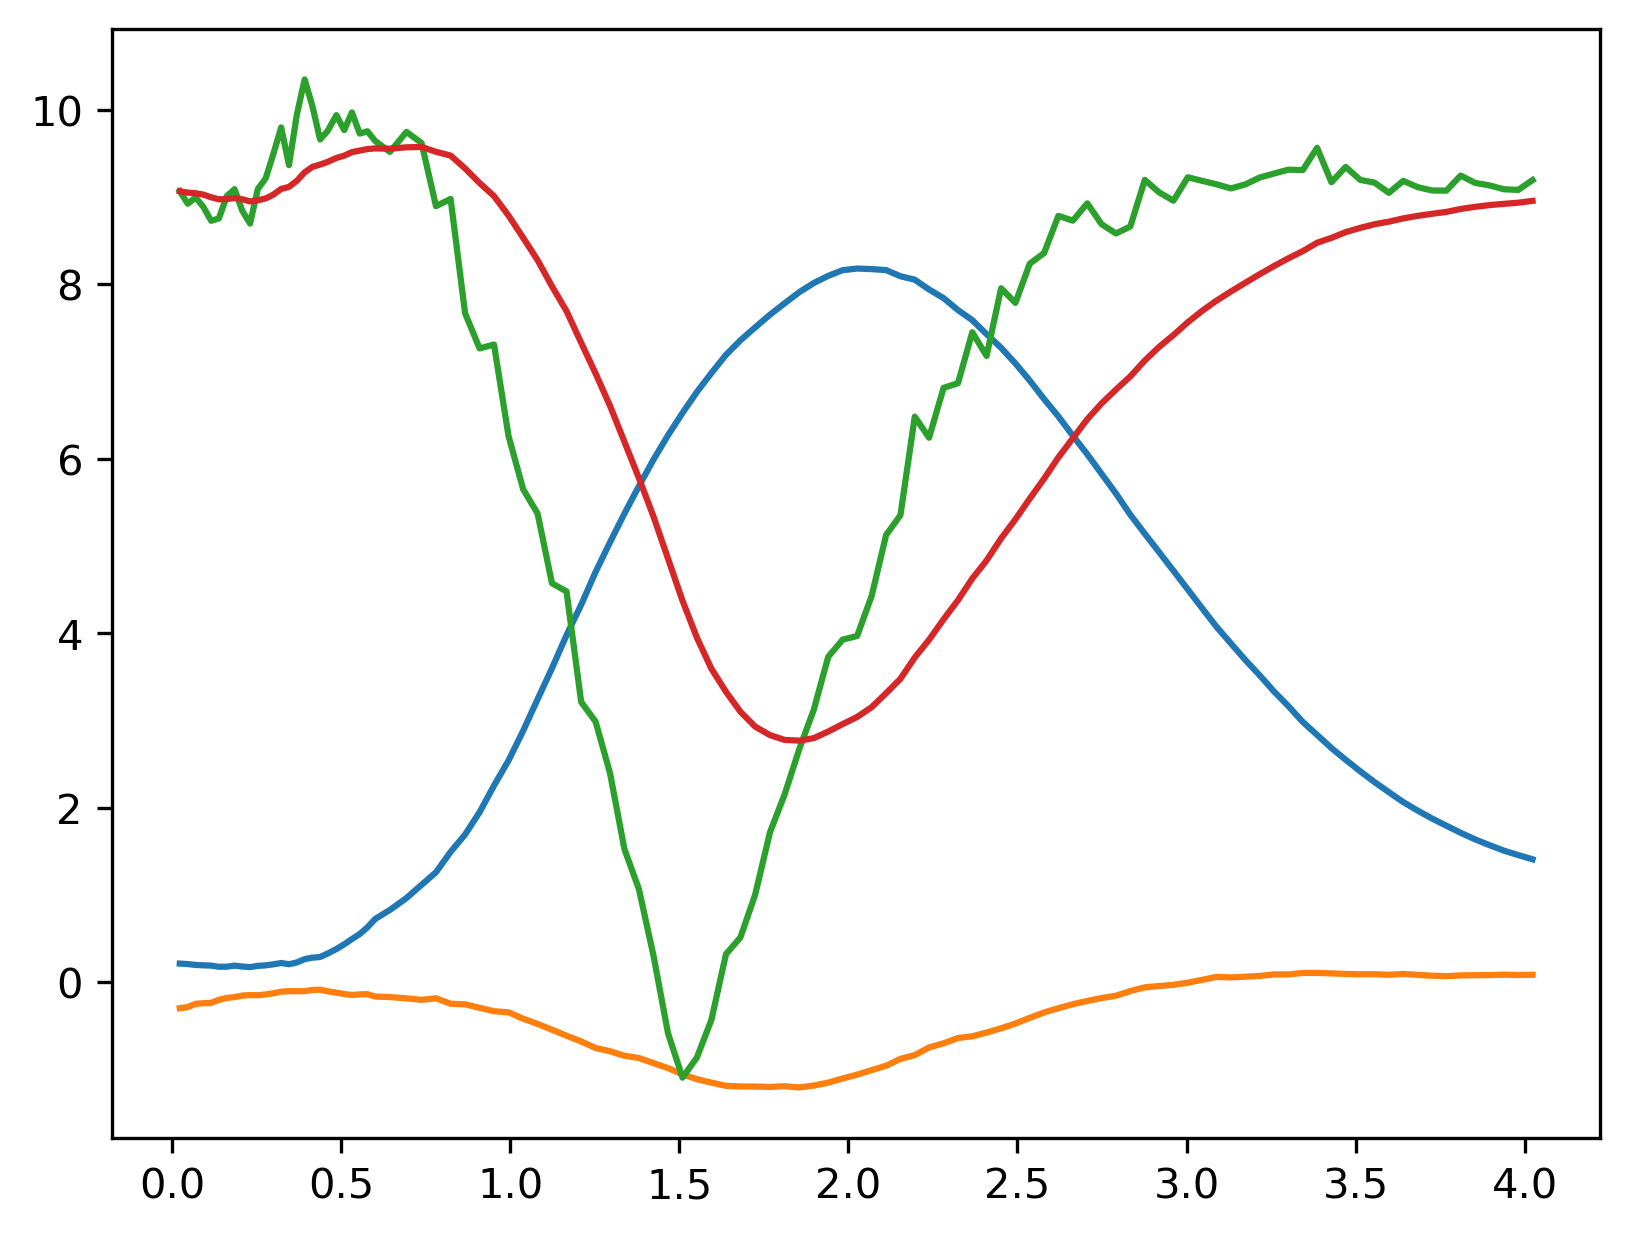

In [93]:
arr4 = loadwithKalman("../imuData/test4.csv")
arr5 = np.loadtxt("../imuData/test4.csv",
                 delimiter=",", dtype=float)
plt.plot(arr4[:,3], arr4[:,0])
plt.plot(arr4[:,3], arr4[:,1])
plt.plot(arr4[:,3], arr5[:,2])
plt.plot(arr4[:,3], arr4[:,2])
# plt.show

[0.02355647 0.02301359 0.02300406 0.02295828 0.02304196 0.02338123
 0.0229249  0.02287626 0.02300739 0.02295232 0.02325296 0.02287531
 0.02293158 0.02308512 0.02324891 0.02304673 0.02285671 0.02291083
 0.0228579  0.02531648 0.02301097 0.02286863 0.02306318 0.02279162
 0.02324224 0.0432806  0.04883456 0.04471278 0.04269576 0.04324436
 0.04278612 0.04291487 0.04265809 0.04289818 0.04326224 0.04268503
 0.0426054  0.04292631 0.04343033 0.04258537 0.04265451 0.04265547
 0.04274321 0.04346514 0.04269314 0.04282212 0.04265237 0.04268551
 0.04324102 0.04265857 0.04343319 0.04401326 0.04353237 0.04335499
 0.0427084  0.04264808 0.04270506 0.0427506  0.04316759 0.04250193
 0.04234004 0.0424273  0.0423224  0.04287863 0.04262567 0.04227352
 0.04229569 0.04296494 0.04227829 0.04244757 0.04223037 0.04238057
 0.04290581 0.04253268 0.0424087  0.04230809 0.04254127 0.04289031
 0.04248762 0.04227543 0.04235125 0.04256558 0.04285574 0.0422833
 0.0422802  0.04228258 0.04233527 0.0429213  0.04253292 0.04237

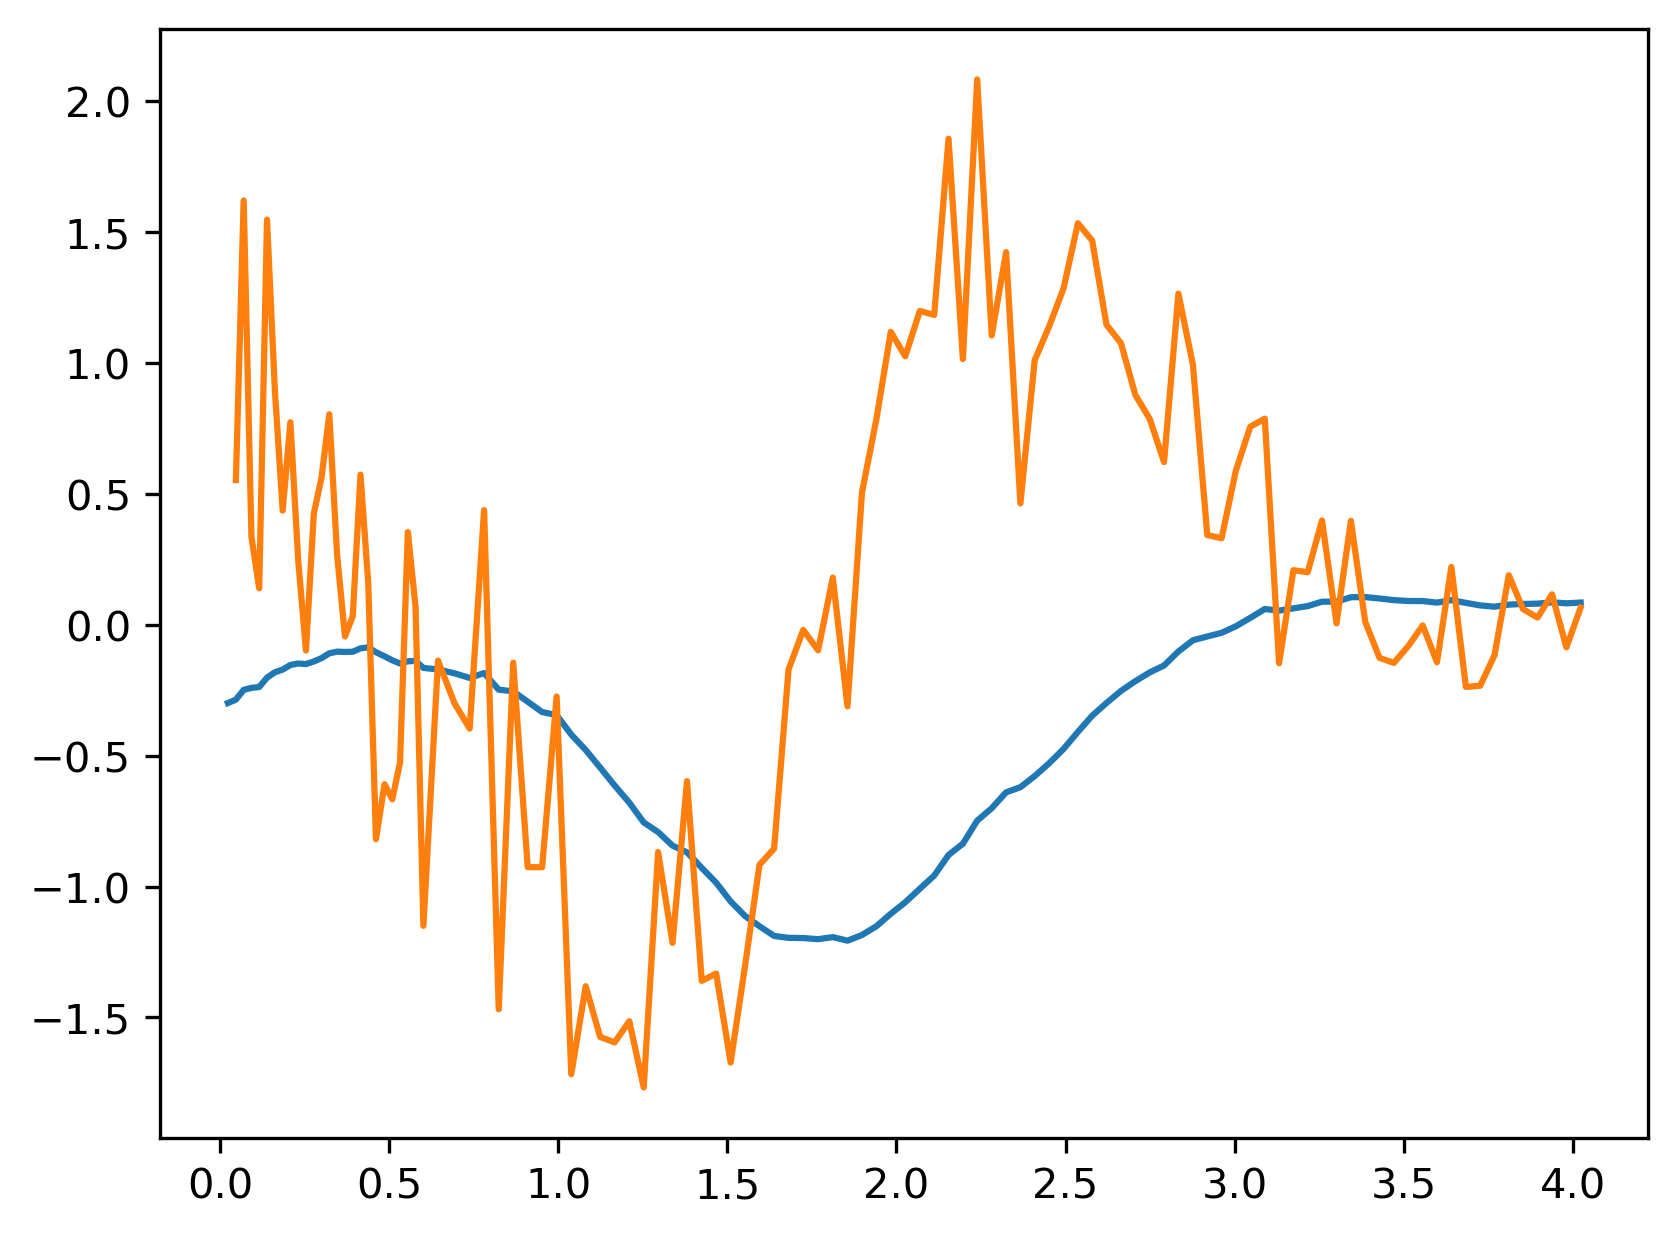

In [94]:

dx = (np.diff(arr4[:,0]))/np.diff(arr4[:,3])
dy = (np.diff(arr4[:,1]))/np.diff(arr4[:,3])
dz = (np.diff(arr4[:,2]))/np.diff(arr4[:,3])
# plt.plot(arr4[:,3], arr4[:,0])
# plt.plot(arr4[1:,3], dx)
plt.plot(arr4[:,3], arr4[:,1])
plt.plot(arr4[1:,3], dy)
# plt.plot(arr4[:,3], arr4[:,2])
# plt.plot(arr4[1:,3], dz)
plt.show
print(np.diff(arr4[:,3]))